In [1]:
# !wget http://download.cs.stanford.edu/deep/ForestNetDataset.zip
# !unzip ForestNetDataset.zip

In [15]:
# !wget https://media.githubusercontent.com/media/BioWar/Satellite-Image-Segmentation-using-Deep-Learning-for-Deforestation-Detection/main/Dataset/deforestation_tfrecords.tar.gz
# !tar -zxf deforestation_tfrecords.tar.gz
# !rm deforestation_tfrecords.tar.gz

In [3]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [5]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from shapely.geometry.polygon import Polygon
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
import random

# df = pd.read_csv('ForestNetDataset/train.csv')
# df.head()

In [7]:
# index = 7
# path = os.path.join('ForestNetDataset', df.iloc[index,-1])
# images = sorted(glob(f'{path}/**/*.png',recursive=True))
# images, df.iloc[index, 1:5]

In [8]:
# import pickle

# with open(f'{path}/forest_loss_region.pkl', 'rb') as fopen:
#     data = pickle.load(fopen)
    
# data

In [9]:
# points = []
# if isinstance(data, Polygon):
#     data = [data]
# for p in data:
#     points.append(np.around(np.array(p.exterior.coords.xy).T).astype(np.int32))

In [10]:
# for image in images:
#     print(image)
#     image = imread(image)
#     copied = np.copy(image)
#     mask = np.zeros_like(image)
#     mask = cv2.fillPoly(mask, pts = points, color =(255,0,0))
#     copied = cv2.addWeighted(copied, 1, mask, 0.8, 0)
    
#     plt.subplot(1,2,1)
#     plt.imshow(image)
#     plt.subplot(1,2,2)
#     plt.imshow(copied)

In [122]:
def sometimes(aug): return iaa.Sometimes(0.6, aug)

seq = iaa.Sequential([
    sometimes(iaa.Affine(rotate=(-90, 90))),
    iaa.Add((-5, 5)),
    sometimes(iaa.Clouds()),
    iaa.CropToFixedSize(width=256, height=256),
    sometimes(iaa.MotionBlur(k=3, angle=[-45, 45])),
], random_order=True)

def augmentation(image, ori_mask):
    mask = np.zeros_like(ori_mask)
    mask[:,:,1] = 1.0
    mask = cv2.bitwise_and(mask, ori_mask)
    mask = mask[:,:,1:2]
    if random.random() > 0.5:
        segmap = SegmentationMapsOnImage(mask.astype(np.int32), shape=image.shape)
        img = image.astype(np.uint8)
        images_aug_i, segmaps_aug_i = seq(image=img, segmentation_maps=segmap)
        seg = segmaps_aug_i.draw()[0][:,:,:1]
        seg[seg > 0] = 1
        seg = seg.astype(np.float32)
        images_aug_i = images_aug_i.astype(np.float32) / 255.0
        return images_aug_i, seg
    else:
        print('not random')
        image = resize(image, (256, 256))
        mask = resize(mask, (256, 256))
        mask = np.around(mask)
        return image.astype(np.float32), mask

In [123]:
def _parse_image_function(example_proto):
    image_feature_description = {
        "image": tf.compat.v1.FixedLenFeature([], tf.string),
        "mask": tf.compat.v1.FixedLenFeature([], tf.string),
    }
    features = tf.compat.v1.parse_single_example(example_proto, features=image_feature_description)
    image = tf.image.decode_png(features['image'], channels = 3)
    mask = tf.io.decode_raw(features['mask'], out_type="float")
    mask = tf.reshape(mask, [512, 512, 3])
    mask = tf.cast(mask, tf.float32)
    
    image, mask = tf.compat.v1.numpy_function(augmentation, [image, mask], [tf.float32, tf.float32])
    image = tf.reshape(image, (256, 256, 3))
    mask = tf.reshape(mask, (256, 256, 1))
    features['image'] = image
    features['mask'] = mask
    return features

dataset_path = glob('content/gdrive/MyDrive/Dataset/*.tfrec')
raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
dataset = raw_image_dataset.map(_parse_image_function)
dataset = dataset.make_one_shot_iterator().get_next()

In [124]:
dataset

{'image': <tf.Tensor 'IteratorGetNext_14:0' shape=(256, 256, 3) dtype=float32>,
 'mask': <tf.Tensor 'IteratorGetNext_14:1' shape=(256, 256, 1) dtype=float32>}

In [125]:
sess = tf.Session()

In [130]:
r = sess.run(dataset)
r['image'].max(), np.unique(r['mask'][:,:,0], return_counts = True)

(0.70980394, (array([0., 1.], dtype=float32), array([63948,  1588])))

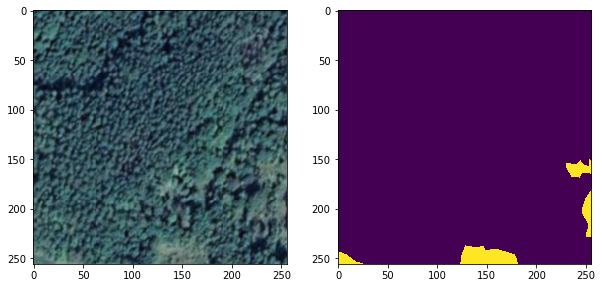

In [131]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(r['image'])
plt.subplot(1,2,2)
plt.imshow(r['mask'][:,:,0])